<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project - Board Games Recommender System

## Problem Statement

Currently most of the methods that people use to seek board game recommendations are video reviews and forum discussion. These are not personalized. The same 'mainstream' games will always be suggested by these platforms.

Hence, as part of a data science team partnered with BoardGameGeek, we want to build a good board game recommender which addresses the following:



1.   Attend to every user's personal needs
2.   Attract new users to BGG community



## History of Board Games

In 3000BC, one of the earliest physical board games, Senet, is first played across Ancient Egypt. The game, which was only seen in the courts of royalty and the upper classes, is the first example of a physical object created for the purposes of a game. Although Senet’s rules are not entirely known, it is featured in ancient hieroglyphs, where it is described as ‘the game of passing’.

In 1900, in Arden, Delaware (US), artist and anti-monopoly protestor Elizabeth Magie creates the first version of her game The Landlord's Game. The game was originally designed as a protest against unfair taxation and monopoly laws in the US, and was later copied and sold to the Parker Brothers Co in the 1930s as the game Monopoly. In 2015 Hasbro (who now own the rights) announced over 1 billion games of Monopoly had been sold worldwide, making it the most popular board game ever created.

In 1995, the first copy of popular German game Settlers of Catan is produced. The hugely popular game is famous as the first Eurogame to ‘break America’, leading to the growing popularity of European-style tabletop games in the US.

Currently in 2020s, there is a worldwide emergence of hybrid games combining multiple genres.

One can understand more from ([*source*](https://boardgamegeek.com/blogpost/67680/timeline-board-game-history)).

In [1]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# use when running from colab
PATH = '/content/drive/MyDrive/Colab Notebooks/BGG Version 3'

# use when running on local machine
# PATH = '../'

In [3]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import MinMaxScaler
import statistics

# Cosine Similarity
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

# Surprise: https://surprise.readthedocs.io/en/stable/
import surprise

from surprise.reader import Reader
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from surprise import accuracy

  ## Cross Validation & Train-Test Split
from surprise.model_selection import cross_validate, train_test_split


  ##Matrix Factorization Algorithms
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor
from surprise import KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore
from surprise import BaselineOnly, CoClustering

np.random.seed(42) # replicating results

## Games Dataset

In [5]:
# Importing games dataset to clean and understand

games = pd.read_csv(f'{PATH}/2022-01-08.csv')

In [6]:
# Looking at the top 5 rows of 'games' dataset

games.head()

,Unnamed: 0,ID,Name,Year,Rank,Average,Bayes average,Users rated,URL,Thumbnail
0,105,30549,Pandemic,2008,106,7.59,7.487,108975,/boardgame/30549/pandemic,https://cf.geekdo-images.com/S3ybV1LAp-8SnHIXL...
1,189,822,Carcassonne,2000,190,7.42,7.309,108738,/boardgame/822/carcassonne,https://cf.geekdo-images.com/okM0dq_bEXnbyQTOv...
2,428,13,Catan,1995,429,7.14,6.970,108024,/boardgame/13/catan,https://cf.geekdo-images.com/W3Bsga_uLP9kO91gZ...
3,72,68448,7 Wonders,2010,73,7.74,7.634,89982,/boardgame/68448/7-wonders,https://cf.geekdo-images.com/RvFVTEpnbb4NM7k0I...
4,103,36218,Dominion,2008,104,7.61,7.499,81561,/boardgame/36218/dominion,https://cf.geekdo-images.com/j6iQpZ4XkemZP07HN...


In [7]:
# Checking the shape to understand the size of 'games' dataset

games.shape

(21831, 10)

In [8]:
# Checking the info to understand the columns and data types

games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21831 entries, 0 to 21830
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     21831 non-null  int64  
 1   ID             21831 non-null  int64  
 2   Name           21831 non-null  object 
 3   Year           21831 non-null  int64  
 4   Rank           21831 non-null  int64  
 5   Average        21831 non-null  float64
 6   Bayes average  21831 non-null  float64
 7   Users rated    21831 non-null  int64  
 8   URL            21831 non-null  object 
 9   Thumbnail      21825 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 1.7+ MB


In [9]:
# Checking which columns have missing value

games.isnull().sum().sort_values(ascending=False)

Thumbnail        6
Unnamed: 0       0
ID               0
Name             0
Year             0
Rank             0
Average          0
Bayes average    0
Users rated      0
URL              0
dtype: int64

In [10]:
# Checking for duplicates
# Occurrence based on all columns

duplicate = games[games.duplicated()]
print("Duplicate Rows :")
 
# Print the resultant Dataframe

duplicate

Duplicate Rows :


,Unnamed: 0,ID,Name,Year,Rank,Average,Bayes average,Users rated,URL,Thumbnail


There is no duplicate

In [11]:
# Using describe() to calculate some statistical data like percentile, mean and std of the numerical values of the DataFrame

games.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,21831.0,10915.00,6302.21,0.00,5457.50,10915.00,16372.50,21830.00
ID,21831.0,118144.78,105369.55,1.00,12308.50,104994.00,207219.00,350992.00
Year,21831.0,1987.44,193.51,0.00,2001.00,2011.00,2017.00,3500.00
Rank,21831.0,10916.00,6302.21,1.00,5458.50,10916.00,16373.50,21831.00
Average,21831.0,6.42,0.93,1.04,5.83,6.45,7.04,9.57
Bayes average,21831.0,5.68,0.36,0.00,5.51,5.54,5.67,8.51
Users rated,21831.0,866.96,3679.82,30.00,56.00,122.00,392.00,108975.00


We noticed that the "year" feature contains values beyond 2022.

### 'Year' Column

In [12]:
# Checking the 'Year' column

games.loc[(games['Year'] > 2022)]

,Unnamed: 0,ID,Name,Year,Rank,Average,Bayes average,Users rated,URL,Thumbnail
208,184,188,Go,2200,185,7.64,7.318,15513,/boardgame/188/go,https://cf.geekdo-images.com/6qAiZwWxSSKP2kFcA...
296,1330,2397,Backgammon,3000,1331,6.54,6.362,12302,/boardgame/2397/backgammon,https://cf.geekdo-images.com/_6HVCuGni6NunlrSj...
3622,8750,2399,Senet,3500,8751,5.81,5.573,718,/boardgame/2399/senet,https://cf.geekdo-images.com/2gkFXJFYi6RAqkSSm...
4088,7947,1602,The Royal Game of Ur,2600,7948,5.98,5.588,607,/boardgame/1602/royal-game-ur,https://cf.geekdo-images.com/DkRLcDIjKsUIh3Dim...
4722,21705,5546,Marbles,3000,21706,4.69,5.317,491,/boardgame/5546/marbles,https://cf.geekdo-images.com/6VcU1PvBIO_tel2zV...
11790,7849,337627,Voidfall,2023,7850,7.68,5.591,105,/boardgame/337627/voidfall,https://cf.geekdo-images.com/hItZjdDTNuaCZ7fEz...
20270,12212,307561,Steam Up: A Feast of Dim Sum,2023,12213,7.57,5.535,35,/boardgame/307561/steam-feast-dim-sum,https://cf.geekdo-images.com/Y4_BmMKtbr7P5tOaR...
21822,17213,11726,Knucklebones,3000,17214,5.78,5.505,30,/boardgame/11726/knucklebones,https://cf.geekdo-images.com/GndZmE6t4SRW0erTI...


From the table above, we can see 2 games with the year '2023'. After researching on the boardgamegeek, this is due to the fact that the physical board game will be released next year in 2023. Hence, I will be keeping these 2 games as 2023.

In [13]:
# Changing the 'Year' beyond 2023 to '0'

games["Year"].replace([2200, 2600, 3000, 3500], 0, inplace=True)

In [14]:
# Checking the 'Year' column does not have values beyond 2023

games.loc[(games['Year'] > 2023)]

,Unnamed: 0,ID,Name,Year,Rank,Average,Bayes average,Users rated,URL,Thumbnail


In order to recommend recent board games, I will only be keeping board games that are published from year 1995 to 2023.

In [15]:
# Dropping rows final_games = final_games.loc[final_games['minplaytime']<240]

games = games.loc[games['Year']>=1995]

In [16]:
# Creating a new column called 'Age' to find the most recent games 

games['Age'] = 2022 - games['Year'] 
games.head()

,Unnamed: 0,ID,Name,Year,Rank,Average,Bayes average,Users rated,URL,Thumbnail,Age
0,105,30549,Pandemic,2008,106,7.59,7.487,108975,/boardgame/30549/pandemic,https://cf.geekdo-images.com/S3ybV1LAp-8SnHIXL...,14
1,189,822,Carcassonne,2000,190,7.42,7.309,108738,/boardgame/822/carcassonne,https://cf.geekdo-images.com/okM0dq_bEXnbyQTOv...,22
2,428,13,Catan,1995,429,7.14,6.970,108024,/boardgame/13/catan,https://cf.geekdo-images.com/W3Bsga_uLP9kO91gZ...,27
3,72,68448,7 Wonders,2010,73,7.74,7.634,89982,/boardgame/68448/7-wonders,https://cf.geekdo-images.com/RvFVTEpnbb4NM7k0I...,12
4,103,36218,Dominion,2008,104,7.61,7.499,81561,/boardgame/36218/dominion,https://cf.geekdo-images.com/j6iQpZ4XkemZP07HN...,14


In [17]:
# Dropping columns

games.drop(['Unnamed: 0', 'URL', 'Thumbnail'], axis=1, inplace=True)

# Checking to see if the correct columns were dropped

games.head()

,ID,Name,Year,Rank,Average,Bayes average,Users rated,Age
0,30549,Pandemic,2008,106,7.59,7.487,108975,14
1,822,Carcassonne,2000,190,7.42,7.309,108738,22
2,13,Catan,1995,429,7.14,6.970,108024,27
3,68448,7 Wonders,2010,73,7.74,7.634,89982,12
4,36218,Dominion,2008,104,7.61,7.499,81561,14


In [18]:
# Changing the columns names to lowercase in order to merge with 'games_info' dataset

games.columns= games.columns.str.lower()

# Checking that it has been changed

games.columns

Index(['id', 'name', 'year', 'rank', 'average', 'bayes average', 'users rated',
       'age'],
      dtype='object')

## Games Information Dataset

In [19]:
# Importing games information dataset to clean and understand

games_info = pd.read_csv(f'{PATH}/games_detailed_info.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (29,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
# Looking at the top 5 rows of 'games _info' dataset

games_info.head()

,Unnamed: 0,type,id,thumbnail,image,primary,alternate,description,yearpublished,minplayers,...,War Game Rank,Customizable Rank,Children's Game Rank,RPG Item Rank,Accessory Rank,Video Game Rank,Amiga Rank,Commodore 64 Rank,Arcade Rank,Atari ST Rank
0,0,boardgame,30549,https://cf.geekdo-images.com/S3ybV1LAp-8SnHIXL...,https://cf.geekdo-images.com/S3ybV1LAp-8SnHIXL...,Pandemic,"['EPIZOotic', 'Pandemia', 'Pandemia 10 Anivers...","In Pandemic, several virulent diseases have br...",2008,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,boardgame,822,https://cf.geekdo-images.com/okM0dq_bEXnbyQTOv...,https://cf.geekdo-images.com/okM0dq_bEXnbyQTOv...,Carcassonne,"['Carcassonne Jubilee Edition', 'Carcassonne: ...",Carcassonne is a tile-placement game in which ...,2000,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,boardgame,13,https://cf.geekdo-images.com/W3Bsga_uLP9kO91gZ...,https://cf.geekdo-images.com/W3Bsga_uLP9kO91gZ...,Catan,"['CATAN', 'Catan (Колонизаторы)', 'Catan telep...","In CATAN (formerly The Settlers of Catan), pla...",1995,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,boardgame,68448,https://cf.geekdo-images.com/RvFVTEpnbb4NM7k0I...,https://cf.geekdo-images.com/RvFVTEpnbb4NM7k0I...,7 Wonders,"['7 csoda', '7 Cudów Świata', '7 divů světa', ...",You are the leader of one of the 7 great citie...,2010,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,boardgame,36218,https://cf.geekdo-images.com/j6iQpZ4XkemZP07HN...,https://cf.geekdo-images.com/j6iQpZ4XkemZP07HN...,Dominion,"['Dominion: Basisspiel', 'Dominion: In naam va...","&quot;You are a monarch, like your parents bef...",2008,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Checking the shape to understand the size of 'games_info' dataset

games_info.shape

(21631, 56)

In [22]:
# Checking the info to understand the columns and data types

games_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21631 entries, 0 to 21630
Data columns (total 56 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     21631 non-null  int64  
 1   type                           21631 non-null  object 
 2   id                             21631 non-null  int64  
 3   thumbnail                      21616 non-null  object 
 4   image                          21616 non-null  object 
 5   primary                        21631 non-null  object 
 6   alternate                      8850 non-null   object 
 7   description                    21630 non-null  object 
 8   yearpublished                  21631 non-null  int64  
 9   minplayers                     21631 non-null  int64  
 10  maxplayers                     21631 non-null  int64  
 11  suggested_num_players          21631 non-null  object 
 12  suggested_playerage            21520 non-null 

In [23]:
# Checking which columns have missing value

games_info.isnull().sum().sort_values(ascending=False)

Atari ST Rank                    21630
Video Game Rank                  21630
Arcade Rank                      21630
Commodore 64 Rank                21630
RPG Item Rank                    21630
Accessory Rank                   21630
Amiga Rank                       21630
Customizable Rank                21330
Party Game Rank                  20984
boardgamecompilation             20804
Children's Game Rank             20755
Abstract Game Rank               20522
Thematic Rank                    20396
boardgameintegration             19900
Family Game Rank                 19304
Strategy Game Rank               19294
War Game Rank                    18130
boardgameimplementation          16769
boardgameexpansion               16125
alternate                        12781
boardgameartist                   5907
boardgamefamily                   3761
boardgamemechanic                 1590
boardgamedesigner                  596
boardgamecategory                  283
suggested_playerage      

In [24]:
# Checking for duplicates
# Occurrence based on all columns

duplicate_games_info = games_info[games_info.duplicated()] 
print("Duplicate Rows :")
 
# Print the resultant Dataframe

duplicate_games_info

Duplicate Rows :


,Unnamed: 0,type,id,thumbnail,image,primary,alternate,description,yearpublished,minplayers,...,War Game Rank,Customizable Rank,Children's Game Rank,RPG Item Rank,Accessory Rank,Video Game Rank,Amiga Rank,Commodore 64 Rank,Arcade Rank,Atari ST Rank


In [25]:
# Using describe() to calculate some statistical data like percentile, mean and std of the numerical values of the DataFrame

games_info.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,21631.0,10815.00,6244.48,0.00,5407.50,10815.00,16222.50,21630.00
id,21631.0,118133.09,105310.42,1.00,12280.50,105187.00,207013.00,350992.00
yearpublished,21631.0,1986.09,210.04,-3500.00,2001.00,2011.00,2017.00,2023.00
minplayers,21631.0,2.01,0.69,0.00,2.00,2.00,2.00,10.00
maxplayers,21631.0,5.71,15.10,0.00,4.00,4.00,6.00,999.00
playingtime,21631.0,90.51,534.83,0.00,25.00,45.00,90.00,60000.00
minplaytime,21631.0,63.65,447.21,0.00,20.00,30.00,60.00,60000.00
maxplaytime,21631.0,90.51,534.83,0.00,25.00,45.00,90.00,60000.00
minage,21631.0,9.61,3.64,0.00,8.00,10.00,12.00,25.00
usersrated,21631.0,875.00,3697.68,29.00,57.00,124.00,397.00,109006.00


## Merging of 'games' dataset and 'games_info' dataset.

In [26]:
# Only keeping these columns from 'games_info' dataset

games_info_new = games_info[['id', 'description', 'minplayers', 'maxplayers',
                             'suggested_num_players', 'suggested_playerage',
                             'playingtime', 'minplaytime', 'maxplaytime', 'minage',
                             'boardgamecategory', 'boardgamemechanic', 'boardgamedesigner',
                             'boardgameartist', 'boardgamepublisher', 'Strategy Game Rank',
                             'Family Game Rank', 'Party Game Rank', 'Abstract Game Rank',
                             'Thematic Rank', 'War Game Rank', 'Customizable Rank',
                             "Children's Game Rank", 'RPG Item Rank', 'Accessory Rank',
                             'Video Game Rank', 'Amiga Rank', 'Commodore 64 Rank',
                             'Arcade Rank', 'Atari ST Rank']]

# Checking to see if the correct columns were keeped

games_info_new.head()

,id,description,minplayers,maxplayers,suggested_num_players,suggested_playerage,playingtime,minplaytime,maxplaytime,minage,...,War Game Rank,Customizable Rank,Children's Game Rank,RPG Item Rank,Accessory Rank,Video Game Rank,Amiga Rank,Commodore 64 Rank,Arcade Rank,Atari ST Rank
0,30549,"In Pandemic, several virulent diseases have br...",2,4,"[OrderedDict([('@numplayers', '1'), ('result',...","[OrderedDict([('@value', '2'), ('@numvotes', '...",45,45,45,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,822,Carcassonne is a tile-placement game in which ...,2,5,"[OrderedDict([('@numplayers', '1'), ('result',...","[OrderedDict([('@value', '2'), ('@numvotes', '...",45,30,45,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13,"In CATAN (formerly The Settlers of Catan), pla...",3,4,"[OrderedDict([('@numplayers', '1'), ('result',...","[OrderedDict([('@value', '2'), ('@numvotes', '...",120,60,120,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,68448,You are the leader of one of the 7 great citie...,2,7,"[OrderedDict([('@numplayers', '1'), ('result',...","[OrderedDict([('@value', '2'), ('@numvotes', '...",30,30,30,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36218,"&quot;You are a monarch, like your parents bef...",2,4,"[OrderedDict([('@numplayers', '1'), ('result',...","[OrderedDict([('@value', '2'), ('@numvotes', '...",30,30,30,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Merging 'games' and 'games_info_new' using the column 'id'
# How = 'right': As 'games_info_new' has 200 lesser rows than 'games'

final_games = pd.merge(left = games,
                       right = games_info_new,
                       how = 'right',
                       on = 'id')

# Checking that it is merged correctly

final_games.head()

,id,name,year,rank,average,bayes average,users rated,age,description,minplayers,...,War Game Rank,Customizable Rank,Children's Game Rank,RPG Item Rank,Accessory Rank,Video Game Rank,Amiga Rank,Commodore 64 Rank,Arcade Rank,Atari ST Rank
0,30549,Pandemic,2008.0,106.0,7.59,7.487,108975.0,14.0,"In Pandemic, several virulent diseases have br...",2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,822,Carcassonne,2000.0,190.0,7.42,7.309,108738.0,22.0,Carcassonne is a tile-placement game in which ...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13,Catan,1995.0,429.0,7.14,6.970,108024.0,27.0,"In CATAN (formerly The Settlers of Catan), pla...",3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,68448,7 Wonders,2010.0,73.0,7.74,7.634,89982.0,12.0,You are the leader of one of the 7 great citie...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36218,Dominion,2008.0,104.0,7.61,7.499,81561.0,14.0,"&quot;You are a monarch, like your parents bef...",2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Using map() function to combine two columns

final_games['name-year'] = final_games['name'].map(str) + '-' + final_games['year'].map(str)


# Checking that it is combined correctly

final_games.head()

,id,name,year,rank,average,bayes average,users rated,age,description,minplayers,...,Customizable Rank,Children's Game Rank,RPG Item Rank,Accessory Rank,Video Game Rank,Amiga Rank,Commodore 64 Rank,Arcade Rank,Atari ST Rank,name-year
0,30549,Pandemic,2008.0,106.0,7.59,7.487,108975.0,14.0,"In Pandemic, several virulent diseases have br...",2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pandemic-2008.0
1,822,Carcassonne,2000.0,190.0,7.42,7.309,108738.0,22.0,Carcassonne is a tile-placement game in which ...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Carcassonne-2000.0
2,13,Catan,1995.0,429.0,7.14,6.970,108024.0,27.0,"In CATAN (formerly The Settlers of Catan), pla...",3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Catan-1995.0
3,68448,7 Wonders,2010.0,73.0,7.74,7.634,89982.0,12.0,You are the leader of one of the 7 great citie...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7 Wonders-2010.0
4,36218,Dominion,2008.0,104.0,7.61,7.499,81561.0,14.0,"&quot;You are a monarch, like your parents bef...",2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dominion-2008.0


In [29]:
# Changing the columns names to lowercase 

final_games.columns= final_games.columns.str.lower()

# Checking that it has been changed

final_games.columns

Index(['id', 'name', 'year', 'rank', 'average', 'bayes average', 'users rated',
       'age', 'description', 'minplayers', 'maxplayers',
       'suggested_num_players', 'suggested_playerage', 'playingtime',
       'minplaytime', 'maxplaytime', 'minage', 'boardgamecategory',
       'boardgamemechanic', 'boardgamedesigner', 'boardgameartist',
       'boardgamepublisher', 'strategy game rank', 'family game rank',
       'party game rank', 'abstract game rank', 'thematic rank',
       'war game rank', 'customizable rank', 'children's game rank',
       'rpg item rank', 'accessory rank', 'video game rank', 'amiga rank',
       'commodore 64 rank', 'arcade rank', 'atari st rank', 'name-year'],
      dtype='object')

In [30]:
# Using describe() to calculate some statistical data like percentile, mean and std of the numerical values of the DataFrame

final_games.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
id,21631.0,118133.09,105310.42,1.00,12280.50,105187.00,207013.00,350992.00
year,17983.0,2011.89,6.75,1995.00,2007.00,2014.00,2017.00,2023.00
rank,17983.0,10334.25,6254.24,1.00,4880.50,10064.00,15651.50,21831.00
average,17983.0,6.50,0.92,1.04,5.93,6.53,7.12,9.57
bayes average,17983.0,5.71,0.38,0.00,5.51,5.55,5.71,8.51
users rated,17983.0,951.67,3953.64,30.00,58.00,133.00,440.00,108975.00
age,17983.0,10.11,6.75,-1.00,5.00,8.00,15.00,27.00
minplayers,21631.0,2.01,0.69,0.00,2.00,2.00,2.00,10.00
maxplayers,21631.0,5.71,15.10,0.00,4.00,4.00,6.00,999.00
playingtime,21631.0,90.51,534.83,0.00,25.00,45.00,90.00,60000.00


We also see some potential anomalies in features such as "maxplayers" and "minplaytime" where the maximum values seem way too high for any board game. We want to investigate this further.

'rank' maximum value is 200 more than the count as 'games_info_new' has 200 lesser rows than 'games'.

### 'maxplayers' Column

In [31]:
# See games with high count for maxplayers

final_games['maxplayers'].value_counts().sort_index(ascending=False)

999       3
362       1
200       1
163       1
127       1
120       1
100      19
99      155
75        2
69        1
68        1
64        1
52        2
50        9
48        1
45        1
42        1
41        1
40        5
38        1
36       11
34        1
33        2
32        3
31        1
30       15
28        2
26        1
25        2
24       16
22        6
21        3
20       65
18       10
17        6
16       66
15       42
14       11
13        7
12      248
11       10
10      413
9        75
8      1218
7       324
6      3969
5      2987
4      6810
3       279
2      4287
1       369
0       164
Name: maxplayers, dtype: int64

In [32]:
# View 20 games with high player counts 99 and beyond

final_games.loc[final_games['maxplayers']>=99].sample(20, random_state=42)

,id,name,year,rank,average,bayes average,users rated,age,description,minplayers,...,customizable rank,children's game rank,rpg item rank,accessory rank,video game rank,amiga rank,commodore 64 rank,arcade rank,atari st rank,name-year
4177,147194,Linkee!,2012.0,4966.0,6.34,5.705,591.0,10.0,Linkee is a trivia party game that can be play...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Linkee!-2012.0
6347,44614,Who Would Win,2009.0,7881.0,6.16,5.590,304.0,13.0,In Who Would Win? two players each draw one ch...,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Who Would Win-2009.0
19483,255335,Shit Happens: Too Shitty for Work,2018.0,15942.0,6.12,5.512,38.0,4.0,Celebrate the shittier side of the 9 to 5 grin...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shit Happens: Too Shitty for Work-2018.0
13064,262381,Amazed: the Game,2018.0,20349.0,4.96,5.477,87.0,4.0,A mind-warping race against the clock! Solve p...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Amazed: the Game-2018.0
18248,24969,Pit Fighter: Fantasy Arena,2006.0,17928.0,5.53,5.501,44.0,16.0,Pit Fighter: Fantasy Arena is a multi mechanic...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pit Fighter: Fantasy Arena-2006.0
3120,141430,Geek Out!,2013.0,10516.0,5.71,5.549,891.0,9.0,Geek Out! is a party game that can determine o...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Geek Out!-2013.0
4450,119866,Wings of Glory: WW1 Rules and Accessories Pack,2012.0,2499.0,7.99,6.008,536.0,10.0,Game description from the publisher:&#10;&#10;...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wings of Glory: WW1 Rules and Accessories Pack...
9288,95765,Joe Name It,2011.0,20448.0,5.28,5.475,162.0,11.0,Can you name a movie with two sequels? How abo...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Joe Name It-2011.0
14895,310408,The Shining: Escape from the Overlook Hotel,2020.0,21160.0,4.39,5.451,67.0,2.0,The Shining: Escape from the Overlook Hotel pu...,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The Shining: Escape from the Overlook Hotel-20...
12893,650,Fairy Meat,2000.0,14808.0,5.97,5.519,89.0,22.0,Fairy Meat is Kenzer &amp; Company's acclaimed...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fairy Meat-2000.0


All these games are not popular (the rank are all very low). But their 'minplayers' are all within a reasonable range. Hence, we would not be dropping any games based on 'maxplayers' column.

### 'minplaytime' Column

In [33]:
# See minplaytime values

final_games['minplaytime'].value_counts().sort_index(ascending=False)

60000      1
17280      1
12000      1
6000       1
5400       1
        ... 
4          5
3         17
2         26
1         56
0        642
Name: minplaytime, Length: 89, dtype: int64

In [34]:
# View 40 games

final_games.loc[final_games['minplaytime']>240].sample(40, random_state=42)

,id,name,year,rank,average,bayes average,users rated,age,description,minplayers,...,customizable rank,children's game rank,rpg item rank,accessory rank,video game rank,amiga rank,commodore 64 rank,arcade rank,atari st rank,name-year
19895,9418,"Eastwall: Battles for the Dnepr, September 194...",1997.0,16920.0,5.94,5.507,36.0,25.0,Eastwall is an operational simulation of the c...,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Eastwall: Battles for the Dnepr, September 194..."
18229,9357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The War in the Pacific 1941-1945&#10;&#10;A tr...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan-nan
19519,6228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Air war over Vietnam, 1965-1972, operational a...",2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan-nan
17758,2299,Lords of the Renaissance,1996.0,15516.0,6.06,5.515,46.0,26.0,Description from the publisher:&#10;&#10;Lords...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lords of the Renaissance-1996.0
15221,8519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[from the box]&#10;You and your guests are the...,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan-nan
5072,3263,Ukraine '43,2000.0,2807.0,7.84,5.950,438.0,22.0,"On August 3rd, 1943, less than two weeks after...",2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ukraine '43-2000.0
13929,11166,Brandywine & Germantown,2000.0,8496.0,7.71,5.577,77.0,22.0,Excerpts from the Clash of Arms website:&#10;&...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Brandywine & Germantown-2000.0
5951,4102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,&quot;Europa Universalis&quot; is a monster wa...,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan-nan
21226,9095,Diplomacy: Classical Variant,1998.0,12869.0,7.54,5.530,31.0,24.0,Rome will be an Empire! This is unless you ha...,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Diplomacy: Classical Variant-1998.0
14619,67084,The War: Europe 1939-1945,2012.0,10401.0,7.27,5.550,70.0,10.0,A board wargame of the European and North Afri...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The War: Europe 1939-1945-2012.0


In general, board games should not extend over the 2-3 hours mark. Despite saying that, there are people who like warfare-style board games such as "Risk", a niche category of games which tend to play over much a much longer time compared to other categories. We also observe that the board games with minimum time above 240 mins are mostly warfare-style games. In order to account for the people who enjoy this genre of games, we will not remove the board games if they are popular.

In [35]:
pop_time_240 = final_games.loc[(final_games['minplaytime'].between(240,480)) & (final_games['users rated'] > 3000)]
pop_time_240

,id,name,year,rank,average,bayes average,users rated,age,description,minplayers,...,customizable rank,children's game rank,rpg item rank,accessory rank,video game rank,amiga rank,commodore 64 rank,arcade rank,atari st rank,name-year
199,233078,Twilight Imperium: Fourth Edition,2017.0,5.0,8.68,8.262,16025.0,5.0,Twilight Imperium (Fourth Edition) is a game o...,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Twilight Imperium: Fourth Edition-2017.0
540,1829,Risk 2210 A.D.,2001.0,1386.0,6.69,6.340,6860.0,21.0,Risk 2210 A.D. is yet another entry in the lon...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Risk 2210 A.D.-2001.0
616,10093,Axis & Allies,2004.0,1431.0,6.70,6.321,5895.0,18.0,Axis &amp; Allies (2004) aka Axis &amp; Allies...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Axis & Allies-2004.0
771,91,Paths of Glory,1999.0,176.0,8.06,7.334,4687.0,23.0,(from GMT Games' website:)&#10;&#10;They calle...,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Paths of Glory-1999.0
1109,875,Roads & Boats,1999.0,456.0,7.73,6.950,3161.0,23.0,"In Roads &amp; Boats, players start with a mod...",1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Roads & Boats-1999.0


In [36]:
# Drop games with minplaytime above 240

final_games = final_games.loc[final_games['minplaytime']<240]
final_games = pd.concat([final_games, pop_time_240], ignore_index=True)

In [37]:
# 'final_games' shape after first-cut cleaning

final_games.shape

(20720, 38)

## Data Dictionary for 'final_games' Dataset

| **Feature**           | **Description**                                                                                                                                                                                                     |
|-----------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| id                    | Board game's ID on BoardGameGeek database.                                                                                                                                                                          |
| year                  | Board game's year of release.                                                                                                                                                                                       |
| rank                  | Board game's overall ranking on the BGG website.                                                                                                                                                                    |
| average               | Board game's average rating given by the BGG community (On a scale of 1-10, 10 being the best while 1 being the worst).                                                                                             |
| bayes average         | Board game's average rating using the Bayesian method.                                                                                                                                                              |
| users rated           | Total number of votes on rating the board game by the BGG community.                                                                                                                                                |
| _age_                 | Board game's age as of 2022.                                                                                                                                                                                        |
| description           | Description of the board game.                                                                                                                                                                                      |
| minplayers            | Minimum number of players for the board game by design.                                                                                                                                                             |
| maxplayers            | Maximum number of players for the board game by design.                                                                                                                                                             |
| suggested_num_players | Best number of players for the board game as suggested by the BGG community.                                                                                                                                        |
| suggested_playerage   | Best age for players to play the board game by design.                                                                                                                                                              |
| playingtime           | How language-dependent components (aside from the rules) are for those who do not speak the game published language (On a scale of 1-5, 5 means no necessary in-game text, 1 means unplayable in another language). |
| minplaytime           | Minimum time required for a single play-through of the board game as stated by the designer.                                                                                                                        |
| maxplaytime           | Maximum time required for a single play-through of the board game as stated by the designer.                                                                                                                        |
| minage                | Minimum age for players to play the board game by design.                                                                                                                                                           |
| boardgamecategory     | Board game's associated categories (e.g. Adventure, Exploration, Fantasy, etc.).                                                                                                                                    |
| boardgamemechanic     | Board game's associated mechanics (e.g. Acting, Memory, Drafting, etc.).                                                                                                                                            |
| boardgamedesigner     | Designer(s) of the board game.                                                                                                                                                                                      |
| boardgameartist       | Artist(s) of the board game and its components.                                                                                                                                                                     |
| boardgamepublisher    | Publisher(s) of the board game.                                                                                                                                                                                     |
| strategy game rank    | Board game's under the category 'strategy' overall ranking on the BGG website.                                                                                                                                      |
| family game rank      | Board game's under the category 'family' overall ranking on the BGG website.                                                                                                                                        |
| party game rank       | Board game's under the category 'party' overall ranking on the BGG website.                                                                                                                                         |
| abstract game rank    | Board game's under the category 'abstract' overall ranking on the BGG website.                                                                                                                                      |
| thematic rank         | Board game's under the category 'thematic' overall ranking on the BGG website.                                                                                                                                      |
| war game rank         | Board game's under the category 'war' overall ranking on the BGG website.                                                                                                                                           |
| customizable rank     | Board game's under the category 'customizable' overall ranking on the BGG website.                                                                                                                                  |
| children's game rank  | Board game's under the category 'children' overall ranking on the BGG website.                                                                                                                                      |
| rpg item rank         | Board game's under the category 'rpg item' overall ranking on the BGG website.                                                                                                                                      |
| accessory rank        | Board game's under the category 'accessory' overall ranking on the BGG website.                                                                                                                                     |
| video game rank       | Board game's under the category 'video' overall ranking on the BGG website.                                                                                                                                         |
| amiga rank            | Board game's under the category 'amiga' overall ranking on the BGG website.                                                                                                                                         |
| commodore 64 rank     | Board game's under the category 'commodore 64' overall ranking on the BGG website.                                                                                                                                  |
| arcade rank           | Board game's under the category 'arcade' overall ranking on the BGG website.                                                                                                                                        |
| atari st rank         | Board game's under the category 'atari st' overall ranking on the BGG website.                                                                                                                                      |
| _name-year_           | Board game's name in English and board game's year of release. (There are games with the same name but released in different year as they are different version of the same game).                                  |

## Further exploring the 'final_games' Data

In [38]:
# Check single entry

final_games.loc[final_games['name']=='Gloomhaven']

,id,name,year,rank,average,bayes average,users rated,age,description,minplayers,...,customizable rank,children's game rank,rpg item rank,accessory rank,video game rank,amiga rank,commodore 64 rank,arcade rank,atari st rank,name-year
26,174430,Gloomhaven,2017.0,1.0,8.74,8.511,47827.0,5.0,Gloomhaven is a game of Euro-inspired tactica...,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Gloomhaven-2017.0


In [39]:
# Check categories for this board game

categories = final_games.loc[final_games['name']=='Gloomhaven', 'boardgamecategory'].values
categories = re.sub(r'[^\w\s]', '', categories[0])
print('Categories\n------------')
print(categories)

Categories
------------
Adventure Exploration Fantasy Fighting Miniatures


In [40]:
# Check mechanics for this board game

mechanics = final_games.loc[final_games['name']=='Gloomhaven', 'boardgamemechanic'].values
mechanics = re.sub(r'[^\w\s]', '', mechanics[0])
print('Mechanics\n------------')
print(mechanics)

Mechanics
------------
Action Queue Action Retrieval Campaign  Battle Card Driven Card Play Conflict Resolution Communication Limits Cooperative Game Critical Hits and Failures Deck Construction Deck Bag and Pool Building Grid Movement Hand Management Hexagon Grid Legacy Game Modular Board OncePerGame Abilities Scenario  Mission  Campaign Game Simultaneous Action Selection Solo  Solitaire Game Storytelling Variable Player Powers


### Board Games Recent Trend

We want to understand the number of board games released over time recently (the last 30 years).

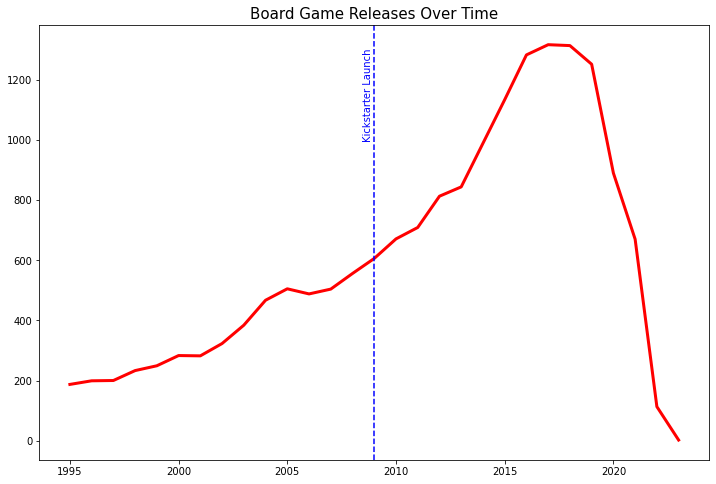

In [41]:
yr_plot = final_games['year'].value_counts().sort_index()

plt.figure(figsize=(12,8))
plt.plot(yr_plot.index, yr_plot.values, linewidth=3, c='r')
plt.title('Board Game Releases Over Time', fontsize=15)
plt.axvline(2009, ls='--', c='b')
plt.text(2008.5, 1000, 'Kickstarter Launch', rotation='vertical', c='b');

From the graph, we can clearly see an upward trend in the number of game published each year. There is a slight dip during 2007-2008. This dip is likely caused by the global financial crisis where economies worldwide were all struggling.

The number of published board games skyrocketed in 2009 as a crowdfunding company called 'Kickstarter' was launched. Kickstarter has been revolutionary to the board game market, as it gives avid gamers a chance to put their ideas out for other like-minded people. In 2015 alone, "Conan" the board game launched a Kickstarter campaign which received full funding of $80,000 within 5 mins from launch. By the end of the campaign, it raised a astounding amount of \$3 million thanks to 15,000 backers ([*source*](https://boardgamegeek.com/blogpost/67680/timeline-board-game-history)).

### Ratings

Ratings for board games are very important as the higher the rating, the more popular it is in the eyes of the public. This means that board games with high popularity would be more recognised when we recommend them to people.







#### Average ratings

Average ratings and Bayesian average ratings are different. Bayesian average ratings are a great way to tackle various problems with a rating system:



*   No one has tried playing all the board games available
*   People only rate the games they are interested in
*   Different people are not consistent in their rating
*   People rate based on their preference

One can understand more from the BGG community discussion ([*source*](https://boardgamegeek.com/thread/71129/what-bayesian-average)).

It is not possible to figure the function used by BGG to calculate the Bayesian average ratings but some leads in the BGG forum reported that there is a minimum of 30 "users rated" to be made for a "bayes average" to be calculated for a board game. Also, only board games with a Bayesian average rating calculated would have a rank. We could see "bayes average" as a good indicator of board games which have at least seen a substantial amount of plays and rates before we can recommend them to others.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


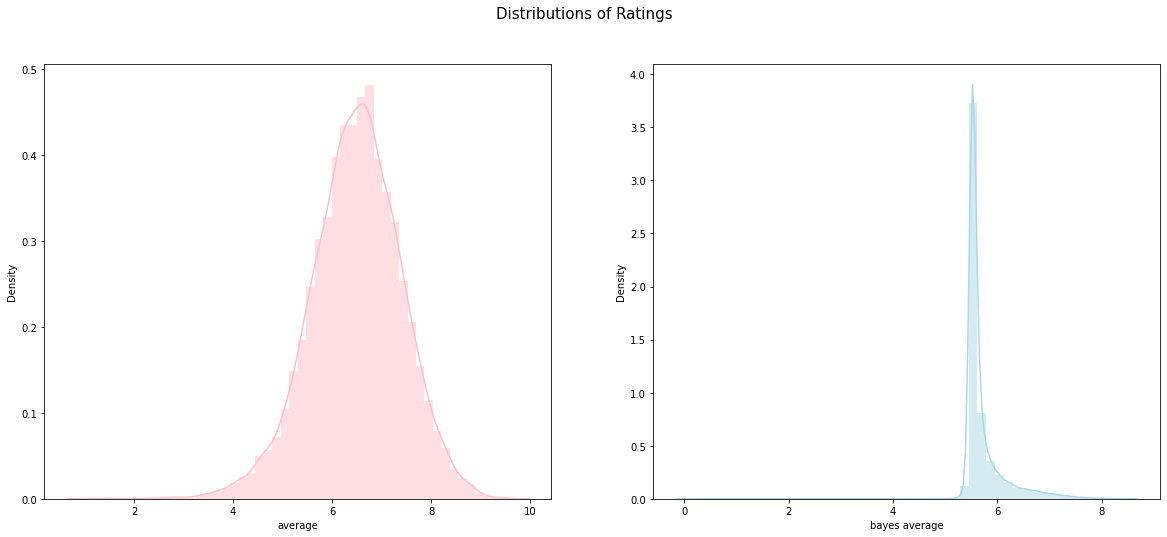

In [42]:
# Plot distributions of bayes average and average

fig, ax = plt.subplots(1,2,figsize=(20,8))
sns.distplot(final_games['average'], ax=ax[0], color='pink', label='Average', hist_kws={'alpha':0.5})
sns.distplot(final_games['bayes average'], ax=ax[1], color='lightblue', label='Bayes Average', hist_kws={'alpha':0.5})
plt.suptitle('Distributions of Ratings', fontsize=15);

From the graph above we can see that the distribution of 'bayes average' is heavily skewed to the right (positive) which might not be ideal when developing a machine learning model using 'bayes average' as a feature of a target. 

In [43]:
# Verify that board games without a rank do not have bayes average

final_games.loc[(final_games['rank']>0) & (final_games['bayes average'].isnull())]

,id,name,year,rank,average,bayes average,users rated,age,description,minplayers,...,customizable rank,children's game rank,rpg item rank,accessory rank,video game rank,amiga rank,commodore 64 rank,arcade rank,atari st rank,name-year


In [44]:
# Verify that board games with less than 30 users rated,
# Do not have bayes average

final_games.loc[(final_games['users rated']>30) & (final_games['bayes average'].isnull())]

,id,name,year,rank,average,bayes average,users rated,age,description,minplayers,...,customizable rank,children's game rank,rpg item rank,accessory rank,video game rank,amiga rank,commodore 64 rank,arcade rank,atari st rank,name-year


We verified that it is indeed true that board games without a Bayesian average rating do not have a rank nor at least 30 numbers of rating from users. These are the board games which we do not want to recommend since they are not as well-received at the time being. As such, we want to drop all the games without a rank or Bayesian average rating.

In [45]:
# Dropping board games without rank or bayes average

final_games = final_games.loc[final_games['rank']>0]
final_games.shape

(17467, 38)

In [46]:
# Check if anymore null values in bayes average

final_games.isnull().sum()

id                           0
name                         0
year                         0
rank                         0
average                      0
bayes average                0
users rated                  0
age                          0
description                  1
minplayers                   0
maxplayers                   0
suggested_num_players        0
suggested_playerage         99
playingtime                  0
minplaytime                  0
maxplaytime                  0
minage                       0
boardgamecategory          258
boardgamemechanic         1248
boardgamedesigner          555
boardgameartist           4103
boardgamepublisher           0
strategy game rank       15349
family game rank         15424
party game rank          16902
abstract game rank       16739
thematic rank            16430
war game rank            15714
customizable rank        17183
children's game rank     16886
rpg item rank            17466
accessory rank           17467
video ga

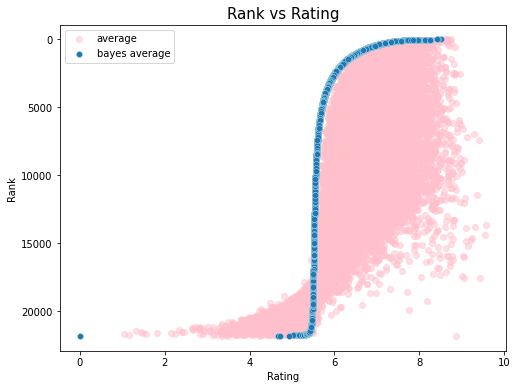

In [47]:
# Plot relationship between rank and bayes average

plt.figure(figsize=(8,6))
ax = plt.gca()

ax.scatter(final_games['average'], final_games['rank'], color='pink', alpha=0.5, label='average')
ax.scatter(final_games['bayes average'], final_games['rank'], edgecolor='lightblue', linewidths=0.5, label='bayes average')
ax.invert_yaxis()
plt.xlabel('Rating')
plt.ylabel('Rank')
plt.legend()
plt.title('Rank vs Rating', fontsize=15);

We could clearly see that the ranking of the board games are correlated to the Bayesian average rating and Average rating. We also noticed the high concentration of board games with a bayesian rating of about 5.5-5.7.

## Categories Rank

In [48]:
#These are the category columns

categories = games_info.columns[43:56] 

# Using the function below to get the number of games under each category

for category in categories:
    num_unique = games_info[category].nunique()
    count = games_info[category].count()
    print('Category:', category, '\n',
          'Number of games:', count, '\n',
          'Has all unique values?', num_unique == count, '\n')

Category: Party Game Rank 
 Number of games: 647 
 Has all unique values? True 

Category: Abstract Game Rank 
 Number of games: 1109 
 Has all unique values? True 

Category: Thematic Rank 
 Number of games: 1235 
 Has all unique values? True 

Category: War Game Rank 
 Number of games: 3501 
 Has all unique values? True 

Category: Customizable Rank 
 Number of games: 301 
 Has all unique values? True 

Category: Children's Game Rank 
 Number of games: 876 
 Has all unique values? True 

Category: RPG Item Rank 
 Number of games: 1 
 Has all unique values? True 

Category: Accessory Rank 
 Number of games: 1 
 Has all unique values? True 

Category: Video Game Rank 
 Number of games: 1 
 Has all unique values? True 

Category: Amiga Rank 
 Number of games: 1 
 Has all unique values? True 

Category: Commodore 64 Rank 
 Number of games: 1 
 Has all unique values? True 

Category: Arcade Rank 
 Number of games: 1 
 Has all unique values? True 

Category: Atari ST Rank 
 Number of games

The most popular category from our dataset is 
War Games at a count of 3,501.

In [49]:
final_games.columns

Index(['id', 'name', 'year', 'rank', 'average', 'bayes average', 'users rated',
       'age', 'description', 'minplayers', 'maxplayers',
       'suggested_num_players', 'suggested_playerage', 'playingtime',
       'minplaytime', 'maxplaytime', 'minage', 'boardgamecategory',
       'boardgamemechanic', 'boardgamedesigner', 'boardgameartist',
       'boardgamepublisher', 'strategy game rank', 'family game rank',
       'party game rank', 'abstract game rank', 'thematic rank',
       'war game rank', 'customizable rank', 'children's game rank',
       'rpg item rank', 'accessory rank', 'video game rank', 'amiga rank',
       'commodore 64 rank', 'arcade rank', 'atari st rank', 'name-year'],
      dtype='object')

In [50]:
# Dropping category rank columns
# As the null values is high and not useful for our recommender

final_games.drop(['strategy game rank', 'family game rank',
       'party game rank', 'abstract game rank', 'thematic rank',
       'war game rank', 'customizable rank', "children's game rank",
       'rpg item rank', 'accessory rank', 'video game rank', 'amiga rank',
       'commodore 64 rank', 'arcade rank', 'atari st rank'], axis=1, inplace=True)

# Checking to see if the correct columns were dropped

final_games.head()

,id,name,year,rank,average,bayes average,users rated,age,description,minplayers,...,playingtime,minplaytime,maxplaytime,minage,boardgamecategory,boardgamemechanic,boardgamedesigner,boardgameartist,boardgamepublisher,name-year
0,30549,Pandemic,2008.0,106.0,7.59,7.487,108975.0,14.0,"In Pandemic, several virulent diseases have br...",2,...,45,45,45,8,['Medical'],"['Action Points', 'Cooperative Game', 'Hand Ma...",['Matt Leacock'],"['Josh Cappel', 'Christian Hanisch', 'Régis Mo...","['Z-Man Games', 'Albi', 'Asmodee', 'Asmodee It...",Pandemic-2008.0
1,822,Carcassonne,2000.0,190.0,7.42,7.309,108738.0,22.0,Carcassonne is a tile-placement game in which ...,2,...,45,30,45,7,"['City Building', 'Medieval', 'Territory Build...","['Area Majority / Influence', 'Map Addition', ...",['Klaus-Jürgen Wrede'],"['Doris Matthäus', 'Anne Pätzke', 'Chris Quill...","['Hans im Glück', '999 Games', 'Albi', 'Bard C...",Carcassonne-2000.0
2,13,Catan,1995.0,429.0,7.14,6.970,108024.0,27.0,"In CATAN (formerly The Settlers of Catan), pla...",3,...,120,60,120,10,"['Economic', 'Negotiation']","['Dice Rolling', 'Hexagon Grid', 'Income', 'Mo...",['Klaus Teuber'],"['Volkan Baga', 'Tanja Donner', 'Pete Fenlon',...","['KOSMOS', '999 Games', 'Albi', 'Asmodee', 'As...",Catan-1995.0
3,68448,7 Wonders,2010.0,73.0,7.74,7.634,89982.0,12.0,You are the leader of one of the 7 great citie...,2,...,30,30,30,10,"['Ancient', 'Card Game', 'City Building', 'Civ...","['Drafting', 'Hand Management', 'Set Collectio...",['Antoine Bauza'],"['Dimitri Chappuis', 'Miguel Coimbra', 'Etienn...","['Repos Production', 'ADC Blackfire Entertainm...",7 Wonders-2010.0
4,36218,Dominion,2008.0,104.0,7.61,7.499,81561.0,14.0,"&quot;You are a monarch, like your parents bef...",2,...,30,30,30,13,"['Card Game', 'Medieval']","['Deck, Bag, and Pool Building', 'Delayed Purc...",['Donald X. Vaccarino'],"['Matthias Catrein', 'Julien Delval', 'Tomasz ...","['Rio Grande Games', '999 Games', 'Albi', 'Bar...",Dominion-2008.0


## Overview of Numerical Variables

Understanding the correlation of the numerical variable.

In [51]:
# List of numerical variables 

num_var = final_games.select_dtypes(exclude='object')
num_var.columns

Index(['id', 'year', 'rank', 'average', 'bayes average', 'users rated', 'age',
       'minplayers', 'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime',
       'minage'],
      dtype='object')

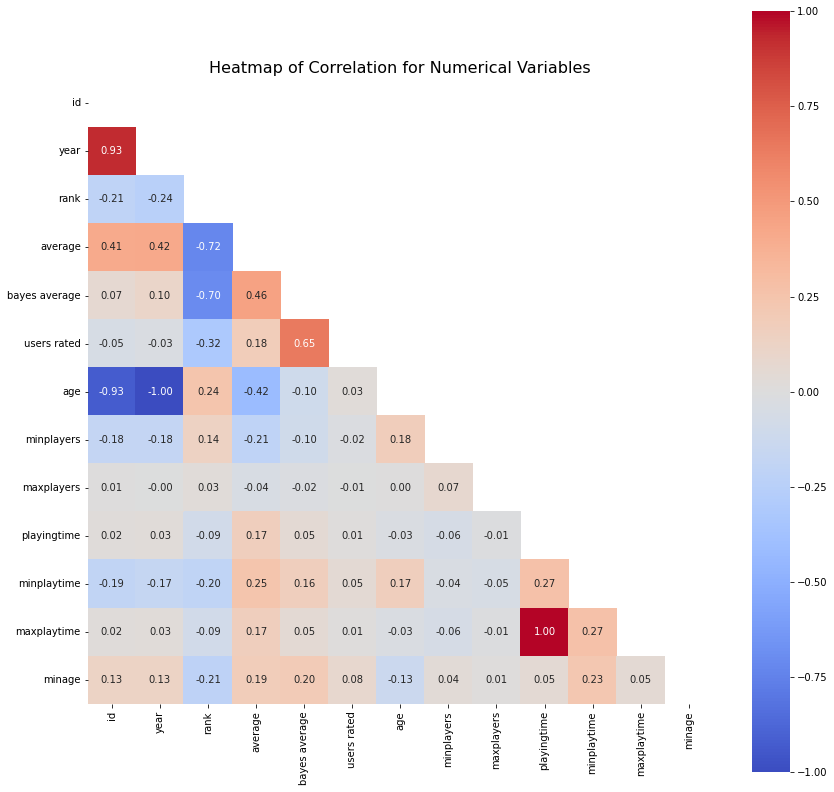

In [52]:
# Plotting a heatmap to see the correlation between the variables

corrmat = num_var.corr()
mask_matrix = np.triu(corrmat)

plt.figure(figsize=(14,14))
plt.title('Heatmap of Correlation for Numerical Variables', fontsize=16)
sns.heatmap(corrmat, cmap='coolwarm', mask=mask_matrix, square=True, annot=True, fmt='.2f', center=0);

## Reviews Dataset

In [53]:
# Importing reviews dataset to clean and understand

reviews = pd.read_csv(f'{PATH}/bgg-19m-reviews.csv')

In [54]:
# Looking at the top 5 rows of 'reviews' dataset

reviews.head()

,Unnamed: 0,user,rating,comment,ID,name
0,0,Torsten,10.0,NaN,30549,Pandemic
1,1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic
2,2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic
3,3,Mike Mayer,10.0,NaN,30549,Pandemic
4,4,Mease19,10.0,This is an amazing co-op game. I play mostly ...,30549,Pandemic


In [55]:
# Checking the shape to understand the size of 'reviews' dataset

reviews.shape

(18964807, 6)

In [56]:
# Checking the info to understand the columns and data types

reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18964807 entries, 0 to 18964806
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   user        object 
 2   rating      float64
 3   comment     object 
 4   ID          int64  
 5   name        object 
dtypes: float64(1), int64(2), object(3)
memory usage: 868.1+ MB


In [57]:
# Checking which columns have missing value

reviews.isnull().sum().sort_values(ascending=False)

comment       15596188
user                66
Unnamed: 0           0
rating               0
ID                   0
name                 0
dtype: int64

In [58]:
# Dropping rows with missing values in the 'reviews' dataset

reviews.dropna(axis=0, inplace=True)

# Checking to see if there is any more missing values

reviews.isnull().sum()

Unnamed: 0    0
user          0
rating        0
comment       0
ID            0
name          0
dtype: int64

In [59]:
# Checking for duplicates
# Occurrence based on all columns

duplicate_reviews = reviews[reviews.duplicated()] 
print("Duplicate Rows :")
 
# Print the resultant Dataframe

duplicate_reviews

Duplicate Rows :


,Unnamed: 0,user,rating,comment,ID,name


In [60]:
# Dropping column

reviews.drop(['Unnamed: 0'], axis=1, inplace=True)

# Checking to see if the correct column was dropped

reviews.head()

,user,rating,comment,ID,name
1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic
2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic
4,Mease19,10.0,This is an amazing co-op game. I play mostly ...,30549,Pandemic
5,cfarrell,10.0,Hey! I can finally rate this game I've been pl...,30549,Pandemic
8,gregd,10.0,Love it- great fun with my son. 2 plays so far...,30549,Pandemic


In [61]:
# Creating a new column to get the number of board games each user rated

reviews['n_games_user_rated'] = reviews['user'].map(reviews['user'].value_counts())

# Checking the dataset

reviews.head()

,user,rating,comment,ID,name,n_games_user_rated
1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic,69
2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic,137
4,Mease19,10.0,This is an amazing co-op game. I play mostly ...,30549,Pandemic,306
5,cfarrell,10.0,Hey! I can finally rate this game I've been pl...,30549,Pandemic,1411
8,gregd,10.0,Love it- great fun with my son. 2 plays so far...,30549,Pandemic,96


In [62]:
# Creating a new column to get the number of user rated the board games

reviews['n_user_rated_games'] = reviews['name'].map(reviews['name'].value_counts())

# Checking the dataset

reviews.head()

,user,rating,comment,ID,name,n_games_user_rated,n_user_rated_games
1,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,30549,Pandemic,69,14521
2,avlawn,10.0,I tend to either love or easily tire of co-op ...,30549,Pandemic,137,14521
4,Mease19,10.0,This is an amazing co-op game. I play mostly ...,30549,Pandemic,306,14521
5,cfarrell,10.0,Hey! I can finally rate this game I've been pl...,30549,Pandemic,1411,14521
8,gregd,10.0,Love it- great fun with my son. 2 plays so far...,30549,Pandemic,96,14521


In [63]:
# Using describe() to calculate some statistical data like percentile, mean and std of the numerical values of the DataFrame

reviews.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
rating,3368619.0,6.91,1.79,0.0,6.0,7.0,8.0,10.0
ID,3368619.0,91353.94,91214.62,1.0,7349.0,50862.0,166384.0,350992.0
n_games_user_rated,3368619.0,271.58,410.63,1.0,37.0,116.0,330.0,3927.0
n_user_rated_games,3368619.0,2112.60,2946.99,1.0,242.0,914.0,2772.0,16627.0


In [64]:
# Will drop the 25% of 'n_games_user_rated' and the 25% of 'n_user_rated_games'

# 'n_games_user_rated'

reviews.drop(reviews[reviews['n_games_user_rated'] < 37].index, inplace=True)

# 'n_user_rated_games'

reviews.drop(reviews[reviews['n_user_rated_games'] < 242].index, inplace=True)

# Checking the 'reviews' shape

reviews.shape

(1894237, 7)

## Data Dictionary for 'reviews' Dataset

| **Feature**        | **Description**                                                                                         |
|--------------------|---------------------------------------------------------------------------------------------------------|
| user               | User's name on BoardGameGeek database.                                                                  |
| rating             | Board game's rating given by each user (On a scale of 1-10, 10 being the best while 1 being the worst). |
| comment            | User's comment on the board game on the BGG website.                                                    |
| id                 | Board game's ID on BoardGameGeek database.                                                              |
| name               | Board game's name on BoardGameGeek database.                                                            |
| n_games_user_rated | Number of board game each user rated.                                                                   |
| n_user_rated_games | Number of user rated each board game.                                                                   |

## Exploring the Data

In [65]:
# Most rated board games

most_rated = reviews['name'].value_counts().head(10)
most_rated

Carcassonne       9331
Catan             8848
Pandemic          8347
7 Wonders         7461
Dominion          7376
Ticket to Ride    7014
Agricola          6881
Puerto Rico       6701
Citadels          6428
Power Grid        6152
Name: name, dtype: int64

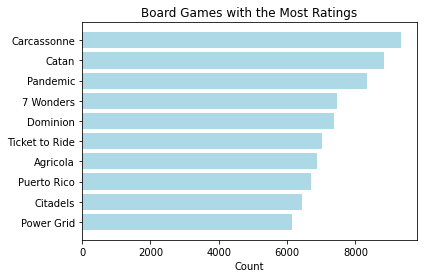

In [66]:
plt.barh(most_rated.index[::-1], most_rated.sort_values(ascending=True), color='lightblue')
plt.title('Board Games with the Most Ratings')
plt.xlabel('Count');

In [67]:
# Least rated board games

least_rated = reviews['name'].value_counts().tail(10)
least_rated

Etherfields                               115
Bloodborne: The Board Game                113
Sorcerer                                  107
Deep Madness                              104
Here to Slay                               97
Blood on the Clocktower                    94
Human Punishment: Social Deduction 2.0     88
The Binding of Isaac: Four Souls           88
Rival Restaurants                          65
Core Space                                 49
Name: name, dtype: int64

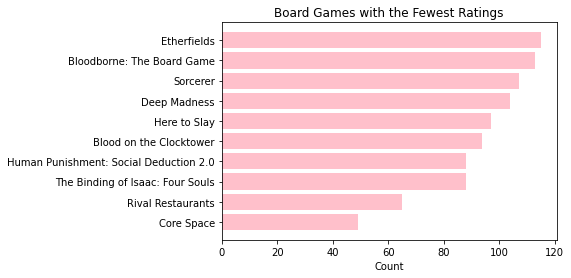

In [68]:
plt.barh(least_rated.index[::-1], least_rated.sort_values(ascending=True), color='pink')
plt.title('Board Games with the Fewest Ratings')
plt.xlabel('Count');

In [69]:
# Top user

top_user = reviews['user'].value_counts().head(10)
top_user

Pandorzecza    2174
Nap16          1731
PBrennan       1631
larryjrice     1447
snoozefest     1245
Thrylos        1227
Walt Mulder    1215
jgoyes         1207
dougadamsau    1177
jtakagi        1105
Name: user, dtype: int64

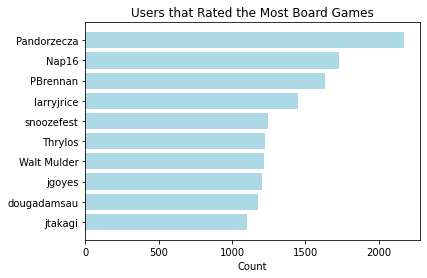

In [70]:
plt.barh(top_user.index[::-1], top_user.sort_values(ascending=True), color='lightblue')
plt.title('Users that Rated the Most Board Games')
plt.xlabel('Count');

In [71]:
# Lowest user

low_user = reviews['user'].value_counts().tail(10)
low_user

wtjBatman         2
Andrew H          2
Bulldog48         2
Mike Duffy        1
dbush1809         1
pilatuspc6        1
ladywargamer66    1
billyboy          1
deraltefritz      1
carlofab          1
Name: user, dtype: int64

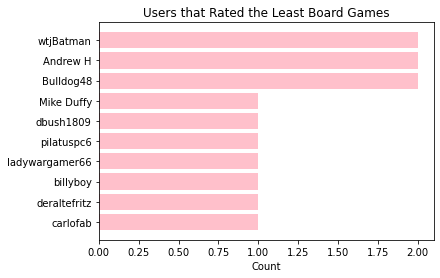

In [72]:
plt.barh(low_user.index[::-1], low_user.sort_values(ascending=True), color='pink')
plt.title('Users that Rated the Least Board Games')
plt.xlabel('Count');

## Collaborative Filtering & Content-based Recommenders

The two main categories of recommender systems are collaborative filtering and content-based filtering. In this part, we will develop recommender systems under these two main categories, using the explicit data collected from the BGG community ratings on board games, and the information given for each board game.


**Collborative filtering** fall under the umbrella of memory-based methods, otherwise referred to as neighborhood-based collaborative filtering. It builds upon the assumption that people will like similar kinds of items as they liked in the past. This system uses the information on ratings (usually) for different users on items. These systems provide recommendations by finding users/items with a rating history similar to the current user or item, and make suggestions via this neighborhood. An advantage of this approach is that the system does not need to "understand" the item itself when making recommendations.

**Content-based filtering** builds upon the description/information of the items. These methods are most suitable when there is data on the different features for each item (name, category, etc.). These systems provide recommendations by finding items similar to what the current user likes based on the item features.

## Preprocessing

A common problem in recommender systems is known as user cold-start, where it is difficult to recommend items for users with very few number of consumed items (in this case rated board games), due to lack of information to model their preferences. Moreover, we would not be able to handle too large a dataset due to lack of computational memory. As such, we choose to only keep
board games which rank is the top 1000. Hence, I will be merging the 'final_games' dataset and 'reviews' dataset.

In [73]:
# Dropping 'name' column

reviews.drop(columns='name', inplace=True)

# Merging the datasets

users_rec = pd.merge(final_games, reviews, left_on='id', right_on='ID').drop(columns='ID')

In [74]:
# Dropping columns 

users_rec.drop(['description', 'minplayers', 'maxplayers',
                'suggested_num_players', 'suggested_playerage', 'playingtime',
                'minplaytime', 'maxplaytime', 'minage', 'boardgamecategory',
                'boardgamemechanic', 'boardgamedesigner', 'boardgameartist',
                'boardgamepublisher'], axis=1, inplace=True)

# Checking to see if the correct columns were dropped

users_rec.head()

,id,name,year,rank,average,bayes average,users rated,age,name-year,user,rating,comment,n_games_user_rated,n_user_rated_games
0,30549,Pandemic,2008.0,106.0,7.59,7.487,108975.0,14.0,Pandemic-2008.0,mitnachtKAUBO-I,10.0,Hands down my favorite new game of BGG CON 200...,69,14521
1,30549,Pandemic,2008.0,106.0,7.59,7.487,108975.0,14.0,Pandemic-2008.0,avlawn,10.0,I tend to either love or easily tire of co-op ...,137,14521
2,30549,Pandemic,2008.0,106.0,7.59,7.487,108975.0,14.0,Pandemic-2008.0,Mease19,10.0,This is an amazing co-op game. I play mostly ...,306,14521
3,30549,Pandemic,2008.0,106.0,7.59,7.487,108975.0,14.0,Pandemic-2008.0,cfarrell,10.0,Hey! I can finally rate this game I've been pl...,1411,14521
4,30549,Pandemic,2008.0,106.0,7.59,7.487,108975.0,14.0,Pandemic-2008.0,gregd,10.0,Love it- great fun with my son. 2 plays so far...,96,14521


In [75]:
# Getting the top 1000 board games based on ranking

top_1000_game = users_rec.loc[(users_rec['rank'] < 1001)]

# Checking the 'top_1000_game' dataset

top_1000_game.shape

(1101944, 14)

In [76]:
# Getting the users who rated at least 100 games

top_user_n_game = top_1000_game[top_1000_game['n_games_user_rated'] >= 100]
top_user_n_game.shape

(733062, 14)

In [77]:
# Number of unique users

top_user_n_game['user'].nunique()

7109

## Normalization

Normalization is the process of scaling down data(in simple words). Usually while normalizing we change the scale of the data to fall between 0–1. Machine learning algorithms tend to perform better or converge faster when the different features (variables) are on a smaller scale. Therefore it is common practice to normalize the data before training machine learning models on it.

To normalize, we subtract the minimum value from each entry and then divide the result by the range. Where range is the difference between the maximum value and the minimum value.

In [78]:
# Copy the data

top_user_n_game = top_user_n_game.copy()
  
# Apply normalization techniques

column = 'rating'
top_user_n_game[column] = MinMaxScaler().fit_transform(np.array(top_user_n_game[column]).reshape(-1,1))
  
# View normalized data 

top_user_n_game.head()

,id,name,year,rank,average,bayes average,users rated,age,name-year,user,rating,comment,n_games_user_rated,n_user_rated_games
1,30549,Pandemic,2008.0,106.0,7.59,7.487,108975.0,14.0,Pandemic-2008.0,avlawn,1.0,I tend to either love or easily tire of co-op ...,137,14521
2,30549,Pandemic,2008.0,106.0,7.59,7.487,108975.0,14.0,Pandemic-2008.0,Mease19,1.0,This is an amazing co-op game. I play mostly ...,306,14521
3,30549,Pandemic,2008.0,106.0,7.59,7.487,108975.0,14.0,Pandemic-2008.0,cfarrell,1.0,Hey! I can finally rate this game I've been pl...,1411,14521
6,30549,Pandemic,2008.0,106.0,7.59,7.487,108975.0,14.0,Pandemic-2008.0,PopeBrain,1.0,(25+ plays) Who can play? Family game for ...,695,14521
7,30549,Pandemic,2008.0,106.0,7.59,7.487,108975.0,14.0,Pandemic-2008.0,ZeeGarcia,1.0,"A thematic, brisk game that is well balanced a...",602,14521


## Sparsity



Sparsity is calculated by the number of cells in a matrix that contain a rating divided by the total number of values that matrix could hold given the number of users and items (board games). In other words, dividing the number of ratings present in the matrix by the product of users and board games in the matrix and subtracting that from 1 will give us the sparsity or the percentage of the ratings matrix that is empty.

In [79]:
# Count the total number of ratings in the dataset

numerator = top_user_n_game['rating'].count()

# Count the number of distinct users and distinct board games

num_users = top_user_n_game['user'].nunique()
num_bgs = top_user_n_game['id'].nunique()

# Set the denominator equal to the number of users multiplied by the number of board games

denominator = num_users * num_bgs

# Divide the numerator by the denominator

sparsity = (1.0 - (numerator *1.0)/denominator)*100
print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  88.96% empty.


## User-Based Collaborative Filtering

The ratings provided by like-minded users of a target user are used in order to make the recommendations for the target user. The basic idea is to determine users, who are similar to the target user, and recommend ratings for the unobserved ratings of the target user by computing weighted averages of the ratings of the peer group. Similarity functions are computed between the rows of the ratings matrix to discover similar users.

### Create a pivot table

Since we are creating an user-based collaboratve recommender, we will set up our pivot table as follows:


1.   'user' will be the index
2.   'name' will be the column
3.   'rating' will be the values





In [80]:
# User-based pivot table

user_pivot = pd.pivot_table(top_user_n_game, index='user', columns='name', values='rating')
user_pivot

name,13 Days: The Cuban Missile Crisis,1775: Rebellion,1812: The Invasion of Canada,1960: The Making of the President,1989: Dawn of Freedom,5-Minute Dungeon,51st State: Master Set,7 Wonders,7 Wonders Duel,878 Vikings: Invasions of England,...,Zendo,ZhanGuo,Zombicide,Zombicide Season 2: Prison Outbreak,Zombicide: Black Plague,Zombicide: Green Horde,Zombicide: Invader,Zombie Kidz Evolution,Zooloretto,ZÈRTZ
user,,,,,,,,,,,,,,,,,,,,,
-Johnny-,NaN,NaN,0.777778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,NaN
0 1 1 2 3 5 8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1 Family Meeple,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.611111,NaN,NaN,...,NaN,NaN,0.555556,NaN,0.666667,0.444444,NaN,NaN,0.666667,NaN
1000rpm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.777778,0.777778,0.888889,...,NaN,NaN,0.777778,NaN,NaN,NaN,NaN,NaN,0.777778,NaN
100pcBlade,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,0.777778,0.777778,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555556,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zunnesteke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.777778,NaN,NaN,...,NaN,0.722222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zurn,NaN,0.666667,NaN,NaN,NaN,NaN,NaN,0.777778,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zurupeto,NaN,NaN,NaN,0.444444,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.555556


### Create sparse matrix

We need to create a sparse matrix.

In [81]:
# Sparse matrix

sparse_user_pivot = sparse.csr_matrix(user_pivot.fillna(0))
sparse_user_pivot

<7109x931 sparse matrix of type '<class 'numpy.float64'>'
	with 730822 stored elements in Compressed Sparse Row format>

In [82]:
# Convert type to save memory

sparse_user_pivot = sparse_user_pivot.astype(np.float32)

## User Similarities

We use the cosine_similarity function to measure the similarity between two users. Essentially the users are treated as vectors and the cosine of the angle between the two vectors would determine whether the two vectors are pointing in roughly the same direction.

In [83]:
# Similarity matrix

user_similarities = cosine_similarity(sparse_user_pivot)
user_similarities

array([[1.0000004 , 0.20088491, 0.08785561, ..., 0.3356484 , 0.26486117,
        0.1128214 ],
       [0.20088491, 0.99999976, 0.228546  , ..., 0.08886377, 0.11761408,
        0.19580919],
       [0.08785561, 0.228546  , 1.0000005 , ..., 0.10834537, 0.1298978 ,
        0.20828341],
       ...,
       [0.3356484 , 0.08886377, 0.10834537, ..., 0.99999976, 0.42719558,
        0.12635918],
       [0.26486117, 0.11761408, 0.1298978 , ..., 0.42719558, 0.9999998 ,
        0.13805404],
       [0.1128214 , 0.19580919, 0.20828341, ..., 0.12635918, 0.13805404,
        1.0000004 ]], dtype=float32)

In [84]:
# Use it as a dataframe

user_cf_df = pd.DataFrame(user_similarities, index=user_pivot.index, columns=user_pivot.index)
user_cf_df.head()

user,-Johnny-,0 1 1 2 3 5 8,1 Family Meeple,1000rpm,100pcBlade,12thManStanding,143245,1awesomeguy,1point21gigawatts,2d20,...,zublord,zugman,zumba,zumby65,zumikon,zunnesteke,zurn,zurupeto,zuviel,zyklonc
user,,,,,,,,,,,,,,,,,,,,,
-Johnny-,1.000000,0.200885,0.087856,0.305254,0.264881,0.116239,0.126418,0.325600,0.143951,0.135845,...,0.154541,0.056905,0.275651,0.087096,0.035110,0.132612,0.310015,0.335648,0.264861,0.112821
0 1 1 2 3 5 8,0.200885,1.000000,0.228546,0.242951,0.152689,0.191318,0.178197,0.141976,0.264268,0.186851,...,0.132558,0.026011,0.171455,0.089128,0.074820,0.080463,0.170759,0.088864,0.117614,0.195809
1 Family Meeple,0.087856,0.228546,1.000000,0.356208,0.280515,0.269958,0.181526,0.131371,0.373557,0.334431,...,0.148460,0.093567,0.172042,0.185822,0.195423,0.181786,0.178298,0.108345,0.129898,0.208283
1000rpm,0.305254,0.242951,0.356208,1.000000,0.400535,0.251065,0.268451,0.297645,0.347388,0.337352,...,0.217798,0.164331,0.463299,0.172041,0.236243,0.298136,0.351454,0.302434,0.321954,0.266694
100pcBlade,0.264881,0.152689,0.280515,0.400535,0.999999,0.278016,0.256870,0.278594,0.294335,0.182322,...,0.324837,0.221208,0.492213,0.105010,0.222989,0.330923,0.326228,0.324740,0.343065,0.388021


## Evaluation of Recommender

We want to evaluate our recommender to see if it matches up to our intuition. We will use an existing user profile in our dataset to do the evaluation.

In [85]:
# Top 10 similar user

search = '-Johnny-'
users = user_pivot[user_pivot.index.str.contains(search)].index

for user in users:
    print(user)
    print('Average rating', user_pivot.loc[user, :].mean())
    print('Number of ratings', user_pivot.T[user].count())
    print('')
    print('10 closest users')
    print(user_cf_df[user].sort_values(ascending=False)[1:11])
    print('')
    print('*******************************************************************************************')
    print('')

-Johnny-
Average rating 0.6241830065359477
Number of ratings 68

10 closest users
user
MattFantastic      0.446422
Shawn_Solo         0.443997
DoomDahDoomDoom    0.439480
HiveGod            0.438110
baldrick           0.437949
thrasymachus       0.425449
ragingoptimist     0.422309
MScrivner          0.416529
hancock.tom        0.413960
gypsylord          0.408320
Name: -Johnny-, dtype: float32

*******************************************************************************************



However, there are some cons of user-based recommender. They are:

1. If a new user has very few likes, for example if we simulate someone who just started trying out board games in general, it is difficult to pair them with a similar user.

2. There is a good chance of re-recommending a board game which the user already owns because similar users may have rated the same games as the user. If we were to filter out the board games to only the ones not owned by the user, we may be left with few recommendations.

## Item-Based Collaborative Filtering

The item-based collaborative recommender will alleviate some of the problems faced by the user-based collaborative recommender. This system will recommend items that are similar to already-liked items. This is done by making the rating predictions for target item by the target user. A set S of items that are most similar to target item is first determined. The ratings in item set S are used to predict whether the target user will like the item. Similarity functions are computed between the columns of the ratings matrix to discover similar items.

### Create a pivot table

Since we are creating an item-based collaboratve recommender, we will set up our pivot table as follows:


1.   'name' will be the index
2.   'user' will be the column
3.   'rating' will be the values

In [86]:
# Item-based pivot table

item_pivot = pd.pivot_table(top_user_n_game, index='name', columns='user', values='rating')
item_pivot

user,-Johnny-,0 1 1 2 3 5 8,1 Family Meeple,1000rpm,100pcBlade,12thManStanding,143245,1awesomeguy,1point21gigawatts,2d20,...,zublord,zugman,zumba,zumby65,zumikon,zunnesteke,zurn,zurupeto,zuviel,zyklonc
name,,,,,,,,,,,,,,,,,,,,,
13 Days: The Cuban Missile Crisis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1775: Rebellion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,NaN,NaN,NaN
1812: The Invasion of Canada,0.777778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960: The Making of the President,NaN,NaN,NaN,NaN,0.333333,NaN,0.555556,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.444444,0.666667,NaN
1989: Dawn of Freedom,NaN,NaN,NaN,NaN,NaN,NaN,0.888889,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zombicide: Green Horde,NaN,NaN,0.444444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zombicide: Invader,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zombie Kidz Evolution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Create sparse matrix

We need to create a sparse matrix.

In [87]:
# Sparse matrix

sparse_item_pivot = sparse.csr_matrix(item_pivot.fillna(0))
sparse_item_pivot

<931x7109 sparse matrix of type '<class 'numpy.float64'>'
	with 730822 stored elements in Compressed Sparse Row format>

## Item Similarities

Similar to the user-based recommender, we use the cosine_similarity function to measure the similarity between two board games.

In [88]:
# Similarity matrix

item_similarities = cosine_similarity(sparse_item_pivot)
item_similarities

array([[1.        , 0.22611834, 0.14777489, ..., 0.05839146, 0.12873235,
        0.12391855],
       [0.22611834, 1.        , 0.34864307, ..., 0.03945491, 0.16572486,
        0.11431279],
       [0.14777489, 0.34864307, 1.        , ..., 0.02901311, 0.17418922,
        0.11061474],
       ...,
       [0.05839146, 0.03945491, 0.02901311, ..., 1.        , 0.06838344,
        0.05338276],
       [0.12873235, 0.16572486, 0.17418922, ..., 0.06838344, 1.        ,
        0.25349512],
       [0.12391855, 0.11431279, 0.11061474, ..., 0.05338276, 0.25349512,
        1.        ]])

In [89]:
# Use it as a dataframe

item_cf_df = pd.DataFrame(item_similarities, index=item_pivot.index, columns=item_pivot.index)
item_cf_df.head()


name,13 Days: The Cuban Missile Crisis,1775: Rebellion,1812: The Invasion of Canada,1960: The Making of the President,1989: Dawn of Freedom,5-Minute Dungeon,51st State: Master Set,7 Wonders,7 Wonders Duel,878 Vikings: Invasions of England,...,Zendo,ZhanGuo,Zombicide,Zombicide Season 2: Prison Outbreak,Zombicide: Black Plague,Zombicide: Green Horde,Zombicide: Invader,Zombie Kidz Evolution,Zooloretto,ZÈRTZ
name,,,,,,,,,,,,,,,,,,,,,
13 Days: The Cuban Missile Crisis,1.000000,0.226118,0.147775,0.203665,0.199484,0.087756,0.152952,0.212463,0.250283,0.162095,...,0.077733,0.149895,0.107774,0.062259,0.118197,0.034952,0.043065,0.058391,0.128732,0.123919
1775: Rebellion,0.226118,1.000000,0.348643,0.224388,0.156423,0.078711,0.119854,0.216611,0.203481,0.285635,...,0.070774,0.093666,0.150649,0.064909,0.128491,0.042134,0.043009,0.039455,0.165725,0.114313
1812: The Invasion of Canada,0.147775,0.348643,1.000000,0.221884,0.181757,0.052263,0.078555,0.204147,0.130497,0.197764,...,0.099308,0.092276,0.137163,0.068632,0.082781,0.027034,0.046664,0.029013,0.174189,0.110615
1960: The Making of the President,0.203665,0.224388,0.221884,1.000000,0.280269,0.066306,0.095307,0.341020,0.213996,0.112435,...,0.159269,0.143604,0.135622,0.057222,0.086017,0.029305,0.033648,0.040444,0.344118,0.232888
1989: Dawn of Freedom,0.199484,0.156423,0.181757,0.280269,1.000000,0.032680,0.075706,0.168365,0.126233,0.097492,...,0.063503,0.109575,0.093907,0.059691,0.049723,0.028379,0.013691,0.038826,0.119513,0.103145


## Evaluation of Recommender

We want to evaluate our recommender to see if it matches up to our intuition. We will use a board game in our dataset to do the evaluation.

In [90]:
# Top 10 similar board games

search = 'Pandemic'
titles = item_pivot[item_pivot.index.str.contains(search)].index

for title in titles:
    print(title)
    print('Average rating', item_pivot.loc[title, :].mean())
    print('Number of ratings', item_pivot.T[title].count())
    print('')
    print('10 closest boardgames')
    print(item_cf_df[title].sort_values(ascending=False)[1:11])
    print('')
    print('*******************************************************************************************')
    print('')

Pandemic
Average rating 0.6955787738574228
Number of ratings 4308

10 closest boardgames
name
Carcassonne            0.695165
Dominion               0.684563
7 Wonders              0.678026
Catan                  0.672158
Ticket to Ride         0.655447
Agricola               0.642257
Small World            0.635539
Power Grid             0.622175
Race for the Galaxy    0.618202
Puerto Rico            0.617889
Name: Pandemic, dtype: float64

*******************************************************************************************

Pandemic Legacy: Season 0
Average rating 0.8518830022075053
Number of ratings 151

10 closest boardgames
name
Pandemic Legacy: Season 2                          0.387114
Pandemic Legacy: Season 1                          0.276099
The Crew: The Quest for Planet Nine                0.227541
Clank!: Legacy – Acquisitions Incorporated         0.218747
Exit: The Game – Dead Man on the Orient Express    0.201691
Pandemic: Iberia                                   

Further reducing the size of the dataset.

In [91]:
# Filtering games (mean of 'n_user_rated_games' = 2112) 

#min_games_ratings = 2112
filter_games = top_user_n_game['name'].value_counts() > 2112
filter_games = filter_games[filter_games].index.tolist()

# Filtering users (mean of 'n_games_user_rated' = 271) 

#min_user_ratings = 271
filter_users = top_user_n_game['user'].value_counts() > 271
filter_users = filter_users[filter_users].index.tolist()

# Creating a new dataframe with 'filter_games' and 'filter_users'

df_new = top_user_n_game[(top_user_n_game['name'].isin(filter_games)) & (users_rec['user'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(users_rec.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(1659510, 14)
The new data frame shape:	(14269, 14)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


## Popularity Model

A common (and usually hard-to-beat) baseline approach is the Popularity model. This model is not actually personalized - it simply recommends to a user the most popular items that the user has not previously consumed. As the popularity accounts for the "wisdom of the crowds", it usually provides good recommendations, generally interesting for most people.
Ps. The main objective of a recommender system is to leverage the long-tail items to the users with very specific interests, which goes far beyond this simple technique.

In [92]:
# Count of user for each unique board game as recommendation score

df_new_grouped = df_new.groupby('name').agg({'user': 'count'}).reset_index()
df_new_grouped.rename(columns = {'user': 'score'},inplace=True)
df_new_grouped.head(20)

,name,score
0,7 Wonders,311
1,7 Wonders Duel,269
2,Agricola,304
3,Alhambra,251
4,Arkham Horror,180
5,Azul,294
6,Battlestar Galactica: The Board Game,227
7,Betrayal at House on the Hill,212
8,Blokus,216
9,Bohnanza,266


In [93]:
# Sort the products on recommendation score

df_new_sort = df_new_grouped.sort_values(['score', 'name'], ascending = [0,1]) 
      
# Generate a recommendation rank based upon score 

df_new_sort['new_rank'] = df_new_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 

popularity_recommendations = df_new_sort.head(5) 
popularity_recommendations 

,name,score,new_rank
13,Citadels,313,1.0
0,7 Wonders,311,2.0
34,Pandemic,310,3.0
31,Love Letter,309,4.0
47,The Castles of Burgundy,307,5.0


In [94]:
# Use popularity based recommender model to make predictions

def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['user'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [95]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the user: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

The list of recommendations for the user: 10

    user                     name  score  new_rank
13    10                 Citadels    313       1.0
0     10                7 Wonders    311       2.0
34    10                 Pandemic    310       3.0
31    10              Love Letter    309       4.0
47    10  The Castles of Burgundy    307       5.0


The list of recommendations for the user: 100

    user                     name  score  new_rank
13   100                 Citadels    313       1.0
0    100                7 Wonders    311       2.0
34   100                 Pandemic    310       3.0
31   100              Love Letter    309       4.0
47   100  The Castles of Burgundy    307       5.0


The list of recommendations for the user: 150

    user                     name  score  new_rank
13   150                 Citadels    313       1.0
0    150                7 Wonders    311       2.0
34   150                 Pandemic    310       3.0
31   150              Love Letter    309

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

Since, it is a Popularity recommender model, so, all the three users are given the same recommendations. Here, we predict the products based on the popularity. It is not personalized to particular user. It is a non-personalized recommender system.

## Matrix Factorization

We will be exploring matrix factorization as we saw the limited capacity of Collaborative Filtering. We are focusing on the RMSE as the metric to evaluate our models.

### Base models

Now we are ready to start modeling. Due to the way the surprise library is built, the way we fit our data for our model with and without GridSearchCV is different. So we will need to redefine our data once we are ready to perform hyper parameter tuning. Let's start with all the base models first.

In [96]:
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(df_new[['user', 'name', 'rating']], reader)

In [97]:
# Creating models dict for modeling function

models = {'baseline': BaselineOnly(),
          'knn_basic': KNNBasic(),
          'knn_zscore': KNNWithZScore(),
          'knn_baseline': KNNBaseline(),
          'svd': SVD(),
          'svdpp': SVDpp(),
          'nmf': NMF(),
          'slope': SlopeOne(),
          'cluster': CoClustering(),
         }

In [98]:
# Creating empty list to store modeling results

model_eval = []

In [99]:
# Function to run model -- input model

def get_base_model_scores(model_name,
                          mod):
    
    """Function accepts following inputs:
    Name of model (str), model to be used (str)."""
    
    # Empty dict for appending results
    results = {}
    
    cross_val_model = cross_validate(models[mod],
                                     data,
                                     measures=['rmse'],
                                     cv=3,
                                     return_train_measures=True,
                                     n_jobs=-1,
                                     verbose=False
                                    )
    
    # Adding model metrics to results
    results['model_name'] = model_name
    results['model'] = mod
    results['train_rmse'] = cross_val_model['train_rmse'].mean()
    results['test_rmse'] = cross_val_model['test_rmse'].mean()
    
    # Using statistics method as the below two attributes
    # Are tuples, so the .mean() method will not work
    # The above are arrays, so the .mean() method works
    
    results['fit_time'] = statistics.mean(cross_val_model['fit_time'])
    results['test_time'] = statistics.mean(cross_val_model['test_time'])
    
    # Adding model scores to evaluation list
    model_eval.append(results)
    print('Base model fit is complete.')
    
    return cross_val_model

Now that we have our modeling function, we will get all of our baseline model scores.

In [100]:
base_baseline_only = get_base_model_scores('base_baseline_only', 'baseline')

Base model fit is complete.


In [101]:
base_knn_basic = get_base_model_scores('base_knn_basic', 'knn_basic')

Base model fit is complete.


In [102]:
#base_knn_means = get_base_model_scores('base_knn_means', 'knn_means')

In [103]:
base_knn_zscore = get_base_model_scores('base_knn_zscore', 'knn_zscore')

Base model fit is complete.


In [104]:
base_knn_baseline = get_base_model_scores('base_knn_baseline', 'knn_baseline')

Base model fit is complete.


In [105]:
base_svd = get_base_model_scores('base_svd', 'svd')

Base model fit is complete.


In [106]:
base_svdpp = get_base_model_scores('base_svdpp', 'svdpp')

Base model fit is complete.


In [107]:
base_nmf = get_base_model_scores('base_nmf', 'nmf')

Base model fit is complete.


In [108]:
base_slop = get_base_model_scores('base_slop', 'slope')

Base model fit is complete.


In [109]:
base_cluster = get_base_model_scores('base_cluster', 'cluster')

Base model fit is complete.


Now let's take a look at the results we have so far.

In [110]:
# Creating dataframe from model_eval scores

base_model_scores = pd.DataFrame(model_eval)

In [111]:
# Sorting by 'test_rmse' metric

base_model_scores.sort_values('test_rmse')

,model_name,model,train_rmse,test_rmse,fit_time,test_time
3,base_knn_baseline,knn_baseline,0.120009,0.150001,0.033616,0.975700
2,base_knn_zscore,knn_zscore,0.117175,0.150521,0.043610,1.016143
0,base_baseline_only,baseline,0.147574,0.151751,0.004664,0.017312
5,base_svdpp,svdpp,0.142540,0.151895,4.901608,0.141806
7,base_slop,slope,0.148444,0.154228,0.013744,0.107877
1,base_knn_basic,knn_basic,0.126169,0.156209,0.031350,1.020611
6,base_nmf,nmf,0.156359,0.162047,0.596797,0.025513
4,base_svd,svd,0.137909,0.162236,0.527252,0.026907
8,base_cluster,cluster,0.638501,0.642543,0.081249,0.016765


Based on the above table, we can see that the lowest (15%) rmse scores are for the KNNBaseline. 

Instead, we will focus on the SVD++ and KNNBaseline.

In the following section, we will tune the hyperparameters of these two models using the surprise library GridSearchCV method.

## Tuning the top model

Since we are using GridSearchCV, we will need to make some changes to our modeling function we used previously. We will also need to re-instantiate our models in the way that is specifically required for GridSearchCV.

In [112]:
model_tuned = {'knn_baseline': KNNBaseline
              }

In [113]:
# Function to run model -- input model

def tuned_model_scores(model_name, 
                       mod, 
                       mod_params={}):
    
    """Function accepts following inputs:
    Name of model (str), model to be used (str), 
    model params(dict, optional)."""
    
    # Empty dict for appending results
    results = {}
    
    # Instantiate GridSearchCV
    gs = GridSearchCV(model_tuned[mod], 
                      param_grid=mod_params,
                      measures=['rmse'],
                      cv=3,
                      n_jobs=-1,
                      return_train_measures=True
                     )

    # Fit model
    gs.fit(data)
    
    temp_df = pd.DataFrame(gs.cv_results)
    num_fits = len(temp_df)*3

    temp_df = temp_df.loc[gs.best_index['rmse'], 
                          ['mean_train_rmse', 
                           'mean_test_rmse', 
                           'mean_fit_time', 
                           'mean_test_time', 
                           'params']].values.tolist()
    
    # Retrieve metrics and add to results
    results['model_name'] = model_name
    results['model'] = mod
    results['train_rmse'] = temp_df[0]
    results['test_rmse'] = temp_df[1]
    results['fit_time'] = temp_df[2]
    results['test_time'] = temp_df[3]
    
    # Add results to list for model evaluation later
    model_eval.append(results)
    
    print(f'{num_fits} fits have been completed.')
    
    return gs

### KNNBaseline Tuning

In [114]:
# Creating separate params for the two different baseline options

# ALS baseline params
knnbase_params_als = {'k': [30, 40], # [20, 30, 40]
                      'min_k': [5, 7 ], # [5, 10, 15]
                      'bsl_options': {'method': ['als'],
                                      'n_epochs': [120, 140], # [30, 50, 100, 120]
                                      'reg_u': [5, 7], # [3, 5, 7]
                                      'reg_i': [1.5, 2] # [0.5, 1, 1.5, 2]
                                  }
                     }

# SGD baseline params
knnbase_params_sgd = {'k': [20, 30], 
                      'min_k': [ 2, 3], 
                      'bsl_options': {'method': ['sgd'], 
                                      'learning_rate': [0.00003, 0.00004]
                                     }
                     }

In [115]:
# Tuning attempt

knn_als_1 = tuned_model_scores('knn_als_1', 
                               'knn_baseline', 
                               mod_params=knnbase_params_als)

96 fits have been completed.


In [116]:
knn_sgd_1 = tuned_model_scores('knn_sgd_1',
                               'knn_baseline', 
                               mod_params=knnbase_params_sgd)

24 fits have been completed.


In [117]:
knn_als_1.best_score

{'rmse': 0.14971987328500133}

In [118]:
knn_sgd_1.best_score

{'rmse': 0.1554366170079323}

In [119]:
knn_als_1.best_params

{'rmse': {'k': 40,
  'min_k': 5,
  'bsl_options': {'method': 'als', 'n_epochs': 140, 'reg_u': 5, 'reg_i': 2}}}

After evaluating the two baseline methods scores, the als baseline showed the most improvement.

In [120]:
model_scores = pd.DataFrame(model_eval)
model_scores[model_scores['model'] == 'knn_baseline']

,model_name,model,train_rmse,test_rmse,fit_time,test_time
3,base_knn_baseline,knn_baseline,0.120009,0.150001,0.033616,0.975700
9,knn_als_1,knn_baseline,0.119596,0.149720,0.168955,1.404586
10,knn_sgd_1,knn_baseline,0.114927,0.155437,0.119028,1.074168


## Results
The best performing model is KNNBaseline model with als, rmse = 0.1497

It is clear that the results are quite close to each other, but strictly speaking, the kNN baseline model with an als method to estimate the baseline performed the best out of the three types.

## Conclusion

With a good recommender system, we can attend to each user's personal needs and attract new users to the BGG community.

## Future Works

The following are some areas that we can improve and test more for future works:



1.   We can try other evaluation metric like precision@K and recall@K.
2.   We can also try out content-based filtering and do a hybrid recommender system with both collaborative filtering and content-based filtering.



